In [3]:
# import warnings
# warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import statistics
# import scimap as sm

import spatialcells as spc


## Read and preprocess data

In [4]:
# single_cell_data_path = ['../../../Cycif/unmicst-1_750_PCA_Mel1.csv'] # for multiple samples
# adata = sm.pp.mcmicro_to_scimap (single_cell_data_path)
# adata.obs["id"] = adata.obs_names
# spc.prep.setGate(adata, "SOX10_cellRingMask", 7.9, debug = True)
# spc.prep.setGate(adata, "MITF_cellRingMask", 6.3, debug = True)
# adata.obs.rename(columns={
#     "SOX10_cellRingMask_positive": "SOX10_positive", 
#     "MITF_cellRingMask_positive": "MITF_positive"
# }, inplace=True)
# pheno_df = ad.read("../../../Cycif/Z147_1_750.h5ad").obs[
#     ["Area", "phenotype", "phenotype_1", "phenotype_2", "phenotype_final", "phenotype_large_cohort"]
# ].copy()
# pheno_df["id"] = range(len(pheno_df))
# adata.obs["id"] = range(len(adata.obs))
# print(all(adata.obs["Area"].to_numpy() == pheno_df["Area"].to_numpy()))
# adata.obs = adata.obs.merge(pheno_df, on=["id", "Area"], how="left")
# adata.obs.index = adata.obs.index.astype(str)

# # Get X and Y centroids in microns
# adata.obs["X_centroid"] = adata.obs["X_centroid"] * 0.6
# adata.obs["Y_centroid"] = adata.obs["Y_centroid"] * 0.6
# adata.obs.head()
adata = ad.read("../../../Cycif/unmicst-1_750_PCA_Mel1.h5ad")

In [5]:
adata.obs["phenotype_large_cohort"].value_counts()

phenotype_large_cohort
Melanocytes                        524293
Unknown                            272275
CD11C+ CD163- cells                137719
CD163+ CD11C+ macrophages           47165
T cells                             33765
Exhausted T cells                   33681
CD163+ CD11C-  macrophages          24332
Regulatory T cells                  18468
Keratinocytes                        6747
CD11C+ CD163- PDL1+ cells            4783
CD163+ CD11C+ PDL1+ macrophages      4227
Cytotoxic T cells                    2764
Langerhans cells                      366
Name: count, dtype: int64

In [6]:
# adata.obs[["phenotype_1", "phenotype_2"]].value_counts().reset_index().sort_values(by=["count"], ascending=False)

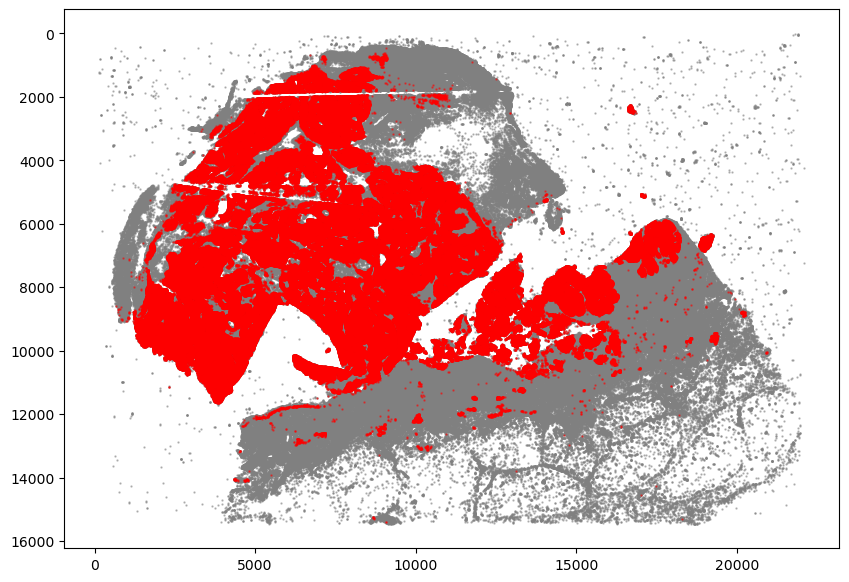

In [7]:
fig, ax = plt.subplots(figsize=(10, 7))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=0.5, color="grey", alpha=0.5)

## SOX10+ cells
tmp = adata[adata.obs.SOX10_positive]
ax.scatter(*zip(*tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=0.5, color="red", alpha=0.5)

ax.invert_yaxis()
plt.show()

## Isolate tumor cell communities and draw region boundary

In [8]:
marker = ["SOX10_positive"]
communitycolumn = "COI_community"
ret = spc.spatial.getCommunities(
    adata, marker, eps= 60, newcolumn = communitycolumn
)


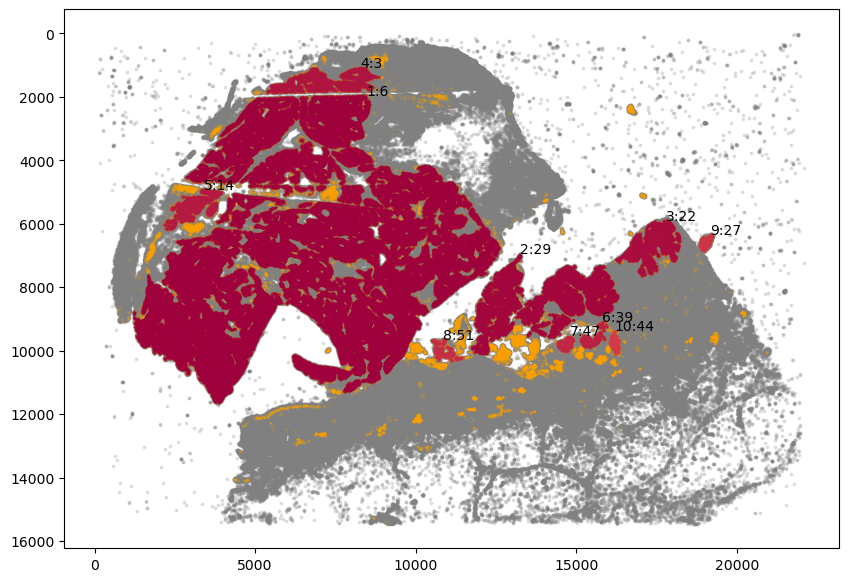

In [9]:
markersize = 0.1

labels_sorted = ret[0]
db = ret[1]
plot_first_n_clusters = 10

adata_tmp = adata[adata.obs[communitycolumn] > -2]
X = adata_tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()
labels = db.labels_
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig, ax = plt.subplots(figsize=(10, 7))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=3, color="grey", alpha=0.2)

# Points of interest: outliers
ax.scatter(X[:,0], X[:,1], alpha=0.5, color="orange", s=markersize/2)

# clusters
idx = 0
for npoints, k in labels_sorted:
    if k == -1:
        continue
    if idx >= plot_first_n_clusters:
        break
        
    col = colors[idx] 
    class_member_mask = labels == k
    mask = class_member_mask & core_samples_mask
    xy = X[mask]
    plt.plot(xy[:, 0],xy[:, 1],
             "o",
             markerfacecolor=tuple(col),
             markeredgecolor=tuple(col),
             markersize=markersize,
            )
    # idx: the "idx" largest cluster
    # k: the cluster
    plt.annotate(str(idx+1)+":"+str(k), (xy[0, 0], xy[0, 1]))

    idx += 1
ax.invert_yaxis()
plt.show()

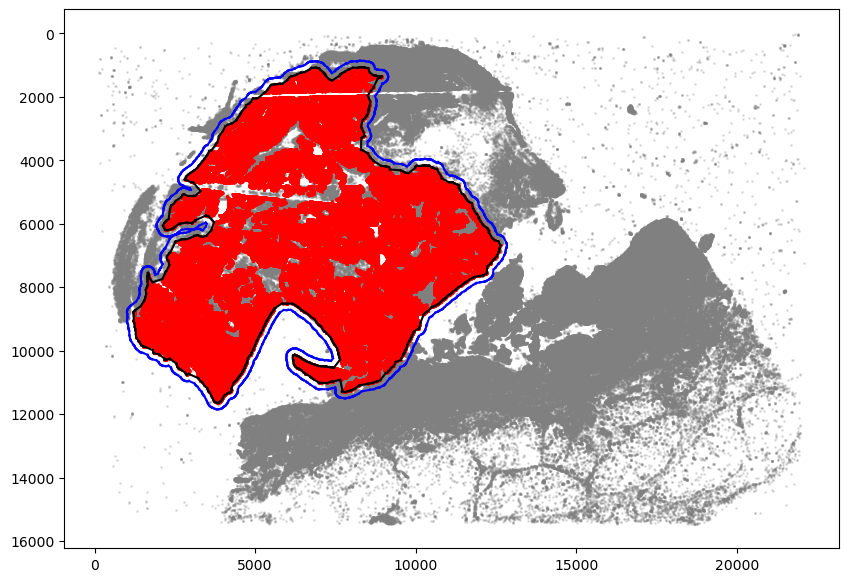

In [10]:
communityIndexList = [6, 3, 14]
boundaries, boundaries_components = spc.spatial.getBoundary(
    adata, communitycolumn, communityIndexList, alpha=200,
    nedges_min = 50, nedges_out_min = 50
)
extended_boundaries, extended_boundary_components = spc.spatial.getExtendedBoundary(
    boundaries_components, offset=200, minsize=20
)
markersize = 1
fig, ax = plt.subplots(figsize=(10, 7))
## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=markersize, color="grey", alpha=0.2)
# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()
ax.scatter(xy[:,0], xy[:,1], s=markersize, color="r")
# Bounds of points in selected commnities
for edge in boundaries:
    ax.plot(edge[:, 0], edge[:, 1], color="k")
# Extended bounds of points in selected commnities
for edge in extended_boundaries:
    ax.plot(edge[:, 0], edge[:, 1], color="b")

ax.invert_yaxis()
plt.show()

### Assign cells to tumor region

100%|██████████| 1110585/1110585 [00:23<00:00, 46846.07it/s] 


Assigned points to region: Tumor


100%|██████████| 530884/530884 [00:09<00:00, 57117.98it/s] 


Assigned points to region: Tumor_edge


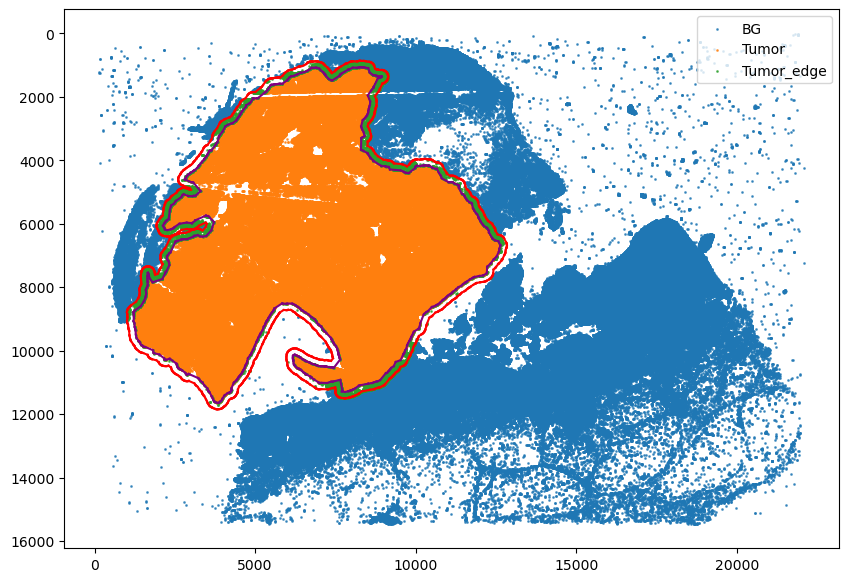

In [11]:
spc.spatial.assignPointsToRegions(
    adata, [boundaries_components, extended_boundary_components], ["Tumor", "Tumor_edge"], 
    assigncolumn="region", default="BG"
)
point_size = 1
fig, ax = plt.subplots(figsize=(10, 7))
for region in sorted(set(adata.obs['region'])):
    tmp = adata.obs[adata.obs.region==region]
    ax.scatter(*zip(*tmp[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=point_size, alpha=0.7, label = region)
# Bounds of points in selected commnities
for ed in boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="purple")
# Extended bounds of points in selected commnities
for ed in extended_boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="red")
plt.legend(loc="upper right")
ax.invert_yaxis()
plt.show()

#### First, we want to know some basic properties of the whole region:

In [12]:
def combine_columns(row):
    if row['MITF_positive'] and row['SOX10_positive']:
        return 'MITF+/SOX10+'
    elif row['MITF_positive']:
        return 'MITF+/SOX10-'
    elif row['SOX10_positive']:
        return 'MITF-/SOX10+'
    else:
        return 'MITF-/SOX10-'

def merge_pheno(row):
    if row["phenotype_large_cohort"].startswith("CD1") or row["phenotype_large_cohort"] in ["Langerhans cells", "Keratinocytes", "Unknown"]:
        return "Other cells"
    elif row["phenotype_large_cohort"] in ["T cells", "Cytotoxic T cells", "Exhausted T cells"]:
        return "T cells"
    else:
        return row["phenotype_large_cohort"]

# Applying the function to create the new column 'c'
adata.obs['pheno'] = pd.Categorical(adata.obs.apply(combine_columns, axis=1))
adata.obs['pheno1'] = pd.Categorical(adata.obs.apply(merge_pheno, axis=1))

In [13]:
tumor_area = spc.tools.getRegionArea(boundaries_components)
overall_density = spc.tools.getRegionDensity(adata, "Tumor", boundaries_components).values[0] * 100**2
density_by_phenotype = spc.tools.getRegionDensity(
    adata, "Tumor", boundaries_components, phenotype_col="pheno1"
) * 100**2
tumor_composition = spc.tools.getRegionComposition(adata, "pheno1", regions=["Tumor"])
print(f"\nTumor area: {tumor_area:.3f}um2")
print(f"\nCell density in tumor area: {overall_density:.3f} cells/100um2")
print(f"\nCell phenotype density in tumor area per 100um2: \n-----------")
print(density_by_phenotype)
print("\nCell phenotype composition in tumor area:\n-----------")
print(tumor_composition)


Tumor area: 67119300.932um2

Cell density in tumor area: 86.369 cells/100um2

Cell phenotype density in tumor area per 100um2: 
-----------
pheno1
Melanocytes           64.819656
Other cells           17.158254
T cells                3.382187
Regulatory T cells     1.008652
Name: count, dtype: float64

Cell phenotype composition in tumor area:
-----------
               pheno1  cell_count  composition
0         Melanocytes      435065     0.750499
1         Other cells      115165     0.198663
2             T cells       22701     0.039160
3  Regulatory T cells        6770     0.011678


In [14]:
spc.tools.getRegionComposition(adata, "pheno1", regions=["Tumor_edge"])

pheno1  cell_count  composition
0         Other cells       14807     0.774830
1         Melanocytes        2535     0.132653
2             T cells        1119     0.058556
3  Regulatory T cells         649     0.033961

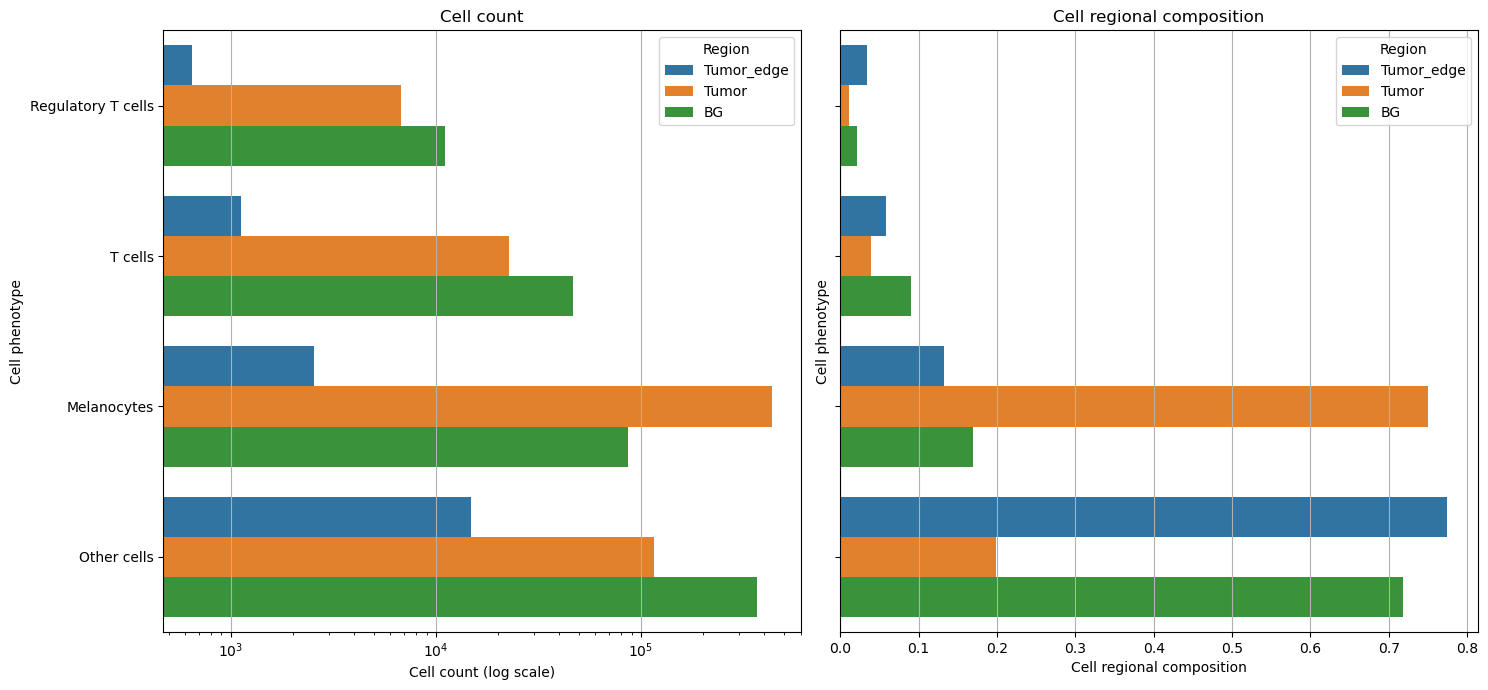

In [15]:
df_bg = spc.tools.getRegionComposition(adata, "pheno1", regions=["BG"])
df_bg["Region"] = "BG"
df_tumor = spc.tools.getRegionComposition(adata, "pheno1", regions=["Tumor"])
df_tumor["Region"] = "Tumor"
df_edge = spc.tools.getRegionComposition(adata, "pheno1", regions=["Tumor_edge"])
df_edge["Region"] = "Tumor_edge"
df = pd.concat([df_bg, df_tumor, df_edge]).sort_values(by=["cell_count"])
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 7), sharey=True)
sns.barplot(
    y="pheno1", x="cell_count", 
    hue="Region", data=df, 
    log=True, order=df["pheno1"].unique(), ax=ax1
)
ax1.set_title("Cell count")
ax1.set_xlabel("Cell count (log scale)")
ax1.set_ylabel("Cell phenotype")
ax1.grid(axis="x")

sns.barplot(
    y="pheno1", x="composition",
    hue="Region", data=df,
    log=False, order=df["pheno1"].unique(), ax=ax2
)
ax2.set_title("Cell regional composition")
ax2.set_xlabel("Cell regional composition")
ax2.set_ylabel("Cell phenotype")
ax2.grid(axis="x")
plt.tight_layout()
plt.show()

In [16]:
df

pheno1  cell_count  composition      Region
3  Regulatory T cells         649     0.033961  Tumor_edge
2             T cells        1119     0.058556  Tumor_edge
1         Melanocytes        2535     0.132653  Tumor_edge
3  Regulatory T cells        6770     0.011678       Tumor
3  Regulatory T cells       11049     0.021590          BG
0         Other cells       14807     0.774830  Tumor_edge
2             T cells       22701     0.039160       Tumor
2             T cells       46390     0.090645          BG
1         Melanocytes       86693     0.169397          BG
1         Other cells      115165     0.198663       Tumor
0         Other cells      367642     0.718368          BG
0         Melanocytes      435065     0.750499       Tumor

In [17]:
spc.tools.getRegionComposition(adata, "phenotype_large_cohort", regions=["BG"])

phenotype_large_cohort  cell_count  composition
0                           Unknown      229138     0.447733
1               CD11C+ CD163- cells       88328     0.172592
2                       Melanocytes       86693     0.169397
3                           T cells       27533     0.053799
4        CD163+ CD11C-  macrophages       22444     0.043855
5                 Exhausted T cells       17231     0.033669
6         CD163+ CD11C+ macrophages       16238     0.031729
7                Regulatory T cells       11049     0.021590
8                     Keratinocytes        5369     0.010491
9         CD11C+ CD163- PDL1+ cells        3793     0.007411
10  CD163+ CD11C+ PDL1+ macrophages        2056     0.004017
11                Cytotoxic T cells        1626     0.003177
12                 Langerhans cells         276     0.000539

# Divide region based on distance from a certain point

In [18]:
centroid = spc.tools.getRegionCentroid(boundaries_components)
edge_pt = [3500, 3500]
spc.tools.getDistanceFromPoint(
    adata, centroid, region=["Tumor"], metric="euclidean", 
    name="euc_distance", binned=True, binsize=1800
)
spc.tools.getDistanceFromPoint(
    adata, centroid, region=["Tumor"], metric="angular", 
    name="ang_distance", binned=True, binsize=45
)

spc.tools.getDistanceFromPoint(
    adata, edge_pt, region=["Tumor"], metric="euclidean", 
    name="euc_edge", binned=True, binsize=2000
)
# spc.tools.getDistanceFromPoint(
#     adata, edge_pt, region=["Tumor"], metric="angular", 
#     name="ang_edge", binned=True, binsize=30
# )

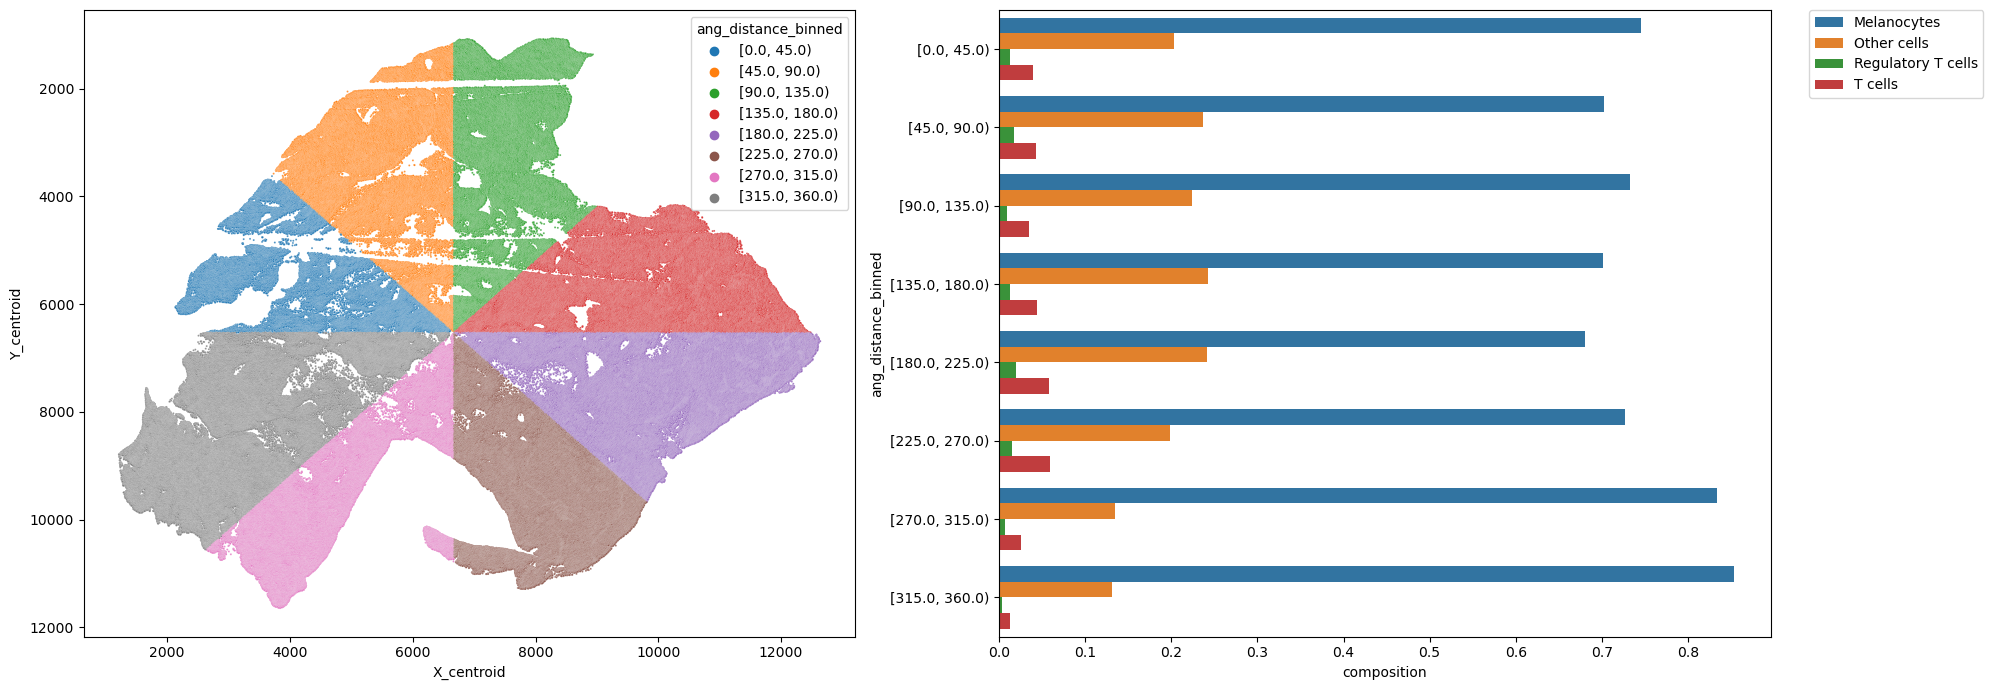

In [19]:
metric_col = "ang_distance_binned"
pheno = "pheno1"
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 7))
sns.scatterplot(data=adata.obs, x="X_centroid", y="Y_centroid", hue=metric_col, alpha=0.8, s=2, ax=ax1)
ax1.invert_yaxis()
df = spc.tools.getRegionComposition(
    adata, [metric_col, pheno], regions=["Tumor"]
).sort_values(by=metric_col, ascending=False)

sns.barplot(data=df, y=metric_col, x="composition", hue=pheno, log=False, ax=ax2)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

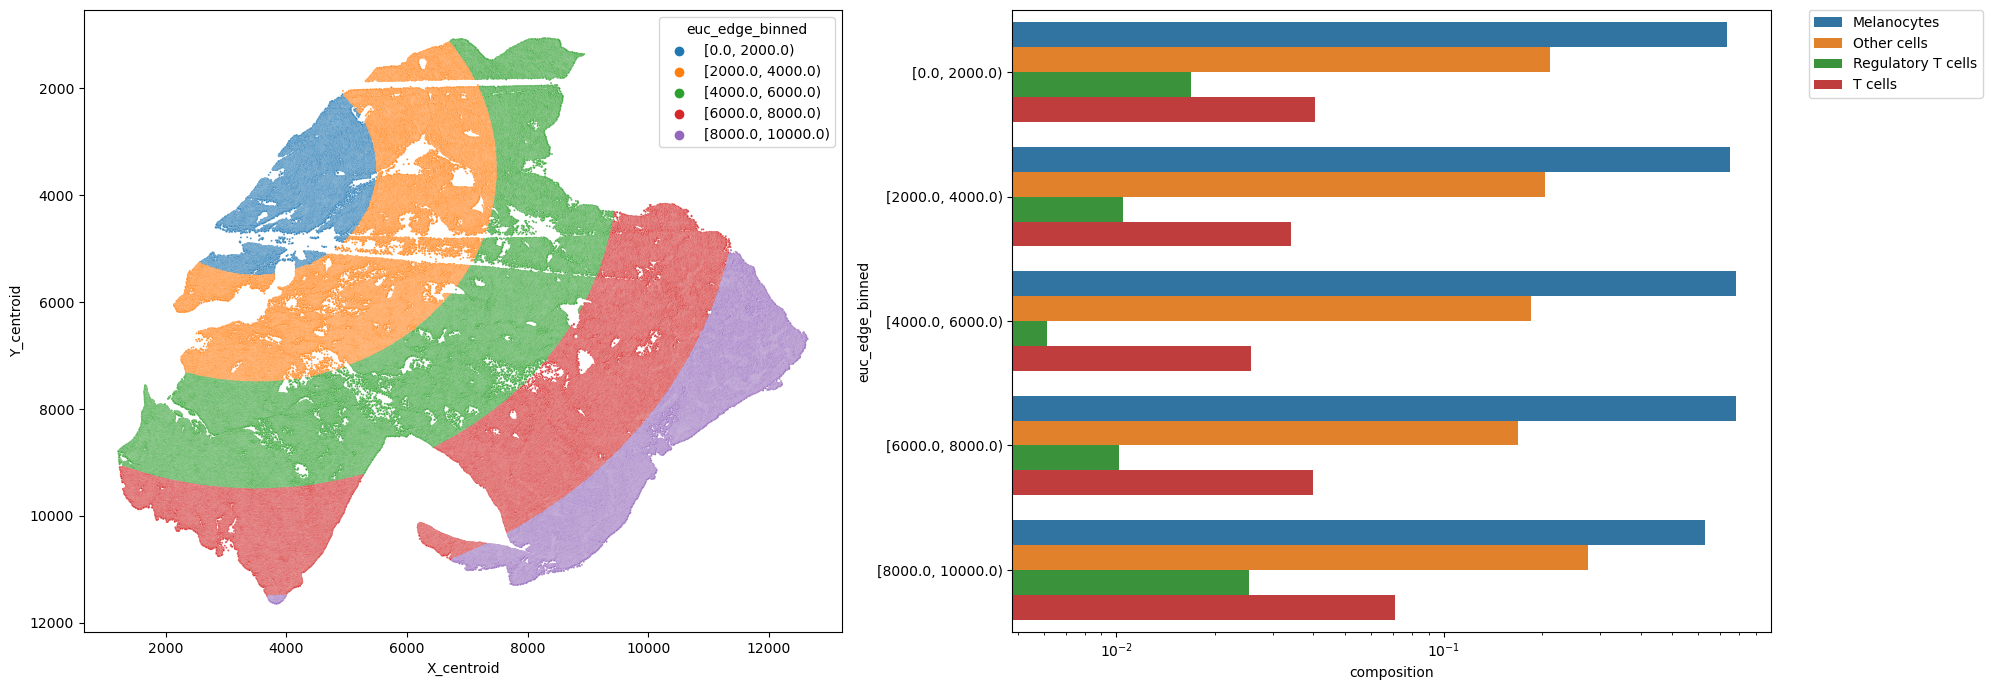

In [20]:
metric_col = "euc_edge_binned"
pheno = "pheno1"
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 7))
sns.scatterplot(data=adata.obs, x="X_centroid", y="Y_centroid", hue=metric_col, alpha=0.8, s=2, ax=ax1)
ax1.invert_yaxis()
df = spc.tools.getRegionComposition(
    adata, [metric_col, pheno], regions=["Tumor"]
).sort_values(by=metric_col, ascending=False)

sns.barplot(data=df, y=metric_col, x="composition", hue=pheno, log=True, ax=ax2)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

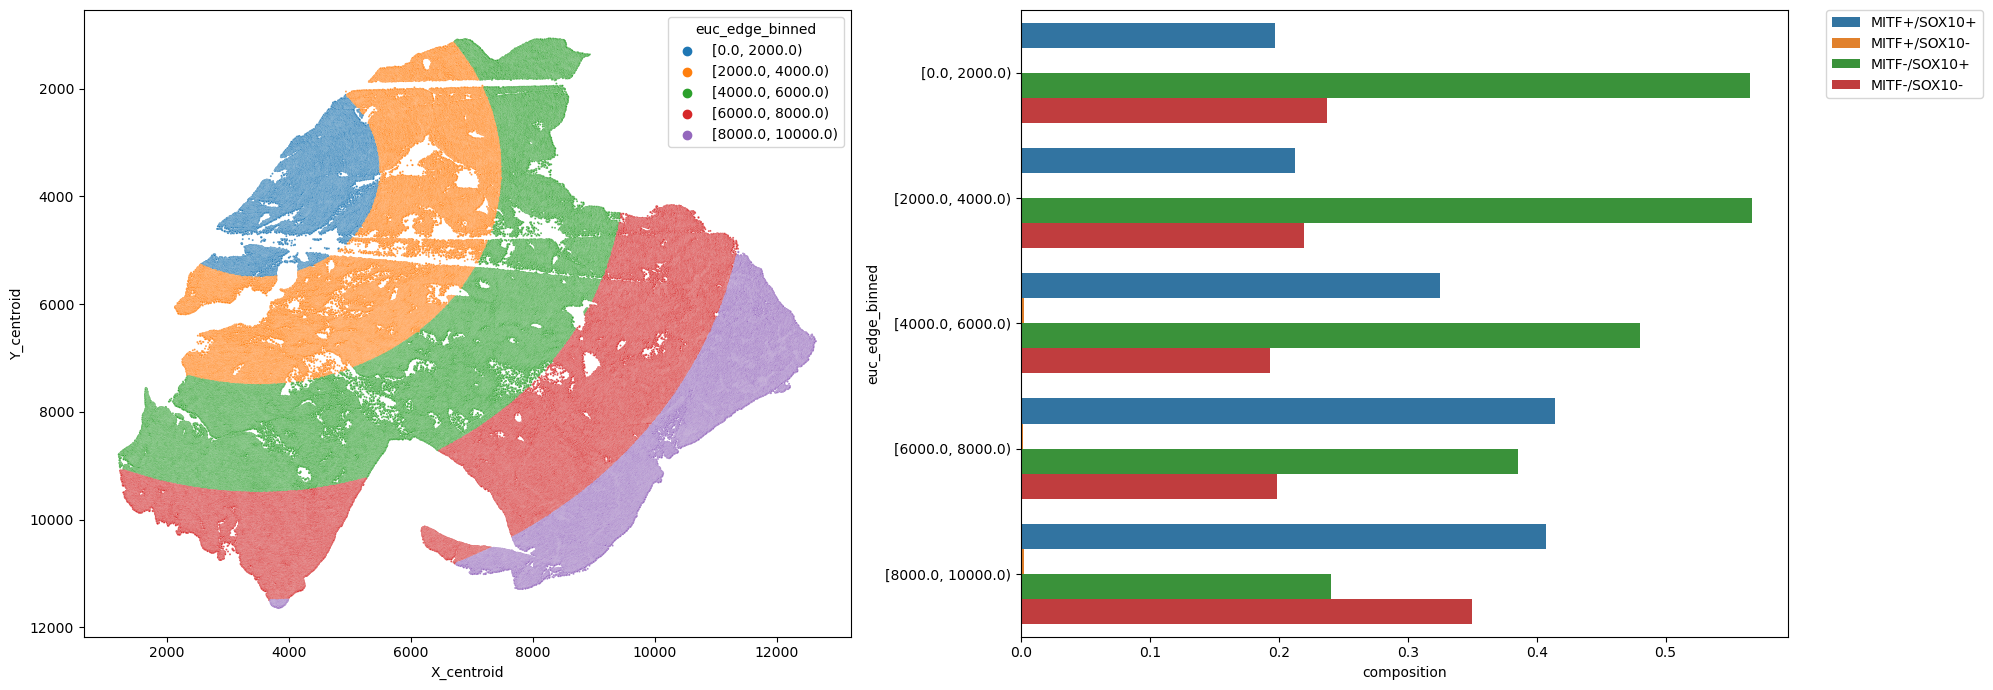

In [21]:
metric_col = "euc_edge_binned"
pheno = "pheno"
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 7))
sns.scatterplot(data=adata.obs, x="X_centroid", y="Y_centroid", hue=metric_col, alpha=0.8, s=2, ax=ax1)
ax1.invert_yaxis()
df = spc.tools.getRegionComposition(
    adata, [metric_col, pheno], regions=["Tumor"]
).sort_values(by=metric_col, ascending=False)

sns.barplot(data=df, y=metric_col, x="composition", hue=pheno, log=False, ax=ax2)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

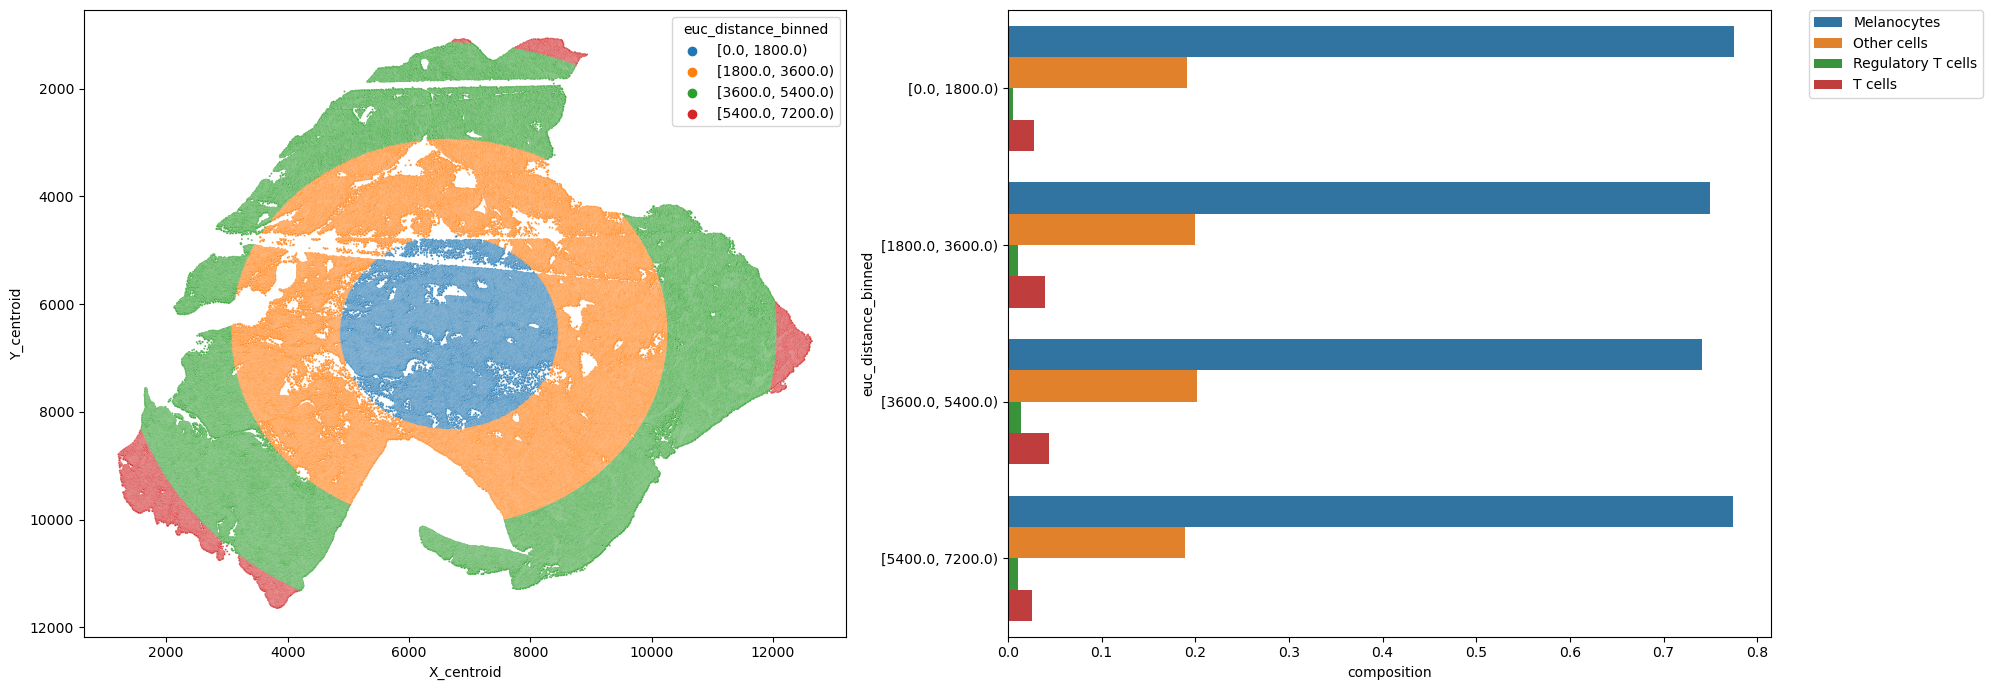

In [22]:
metric_col = "euc_distance_binned"
pheno = "pheno1"
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 7))
sns.scatterplot(data=adata.obs, x="X_centroid", y="Y_centroid", hue=metric_col, alpha=0.8, s=2, ax=ax1)
ax1.invert_yaxis()
df = spc.tools.getRegionComposition(
    adata, [metric_col, pheno], regions=["Tumor"]
).sort_values(by=metric_col, ascending=False)

sns.barplot(data=df, y=metric_col, x="composition", hue=pheno, log=False, ax=ax2)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

# Distance from epidermis cells

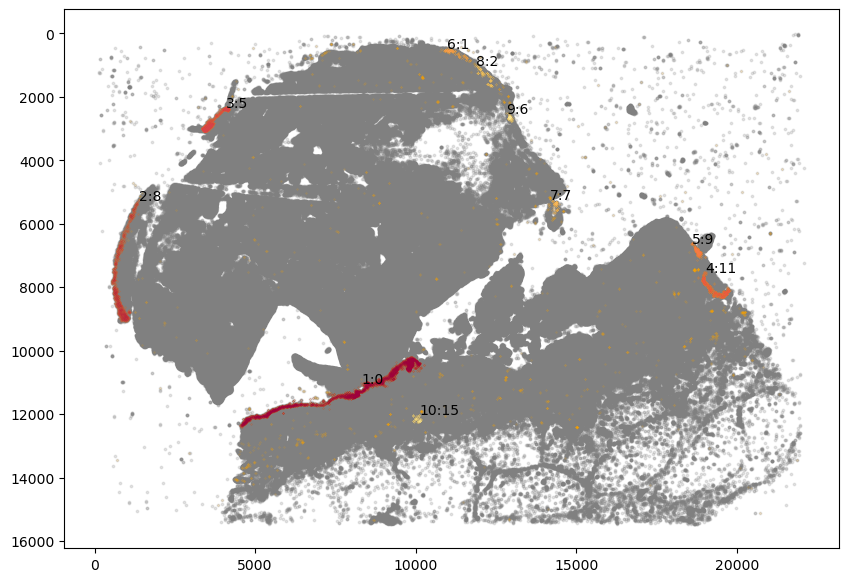

In [28]:
adata.obs["keratinocytes"] = adata.obs["phenotype_large_cohort"].isin(["Keratinocytes"])
marker = ["keratinocytes"]
communitycolumn = "epi_community"
ret = spc.spatial.getCommunities(
    adata, marker, eps= 200, newcolumn = communitycolumn
)
markersize = 0.1

labels_sorted = ret[0]
db = ret[1]
plot_first_n_clusters = 10

adata_tmp = adata[adata.obs[communitycolumn] > -2]
X = adata_tmp.obs[["X_centroid", "Y_centroid"]].to_numpy()
labels = db.labels_
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

fig, ax = plt.subplots(figsize=(10, 7))

## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=3, color="grey", alpha=0.2)

# Points of interest: outliers
ax.scatter(X[:,0], X[:,1], alpha=0.5, color="orange", s=markersize/2)

# clusters
idx = 0
for npoints, k in labels_sorted:
    if k == -1:
        continue
    if idx >= plot_first_n_clusters:
        break
        
    col = colors[idx] 
    class_member_mask = labels == k
    mask = class_member_mask & core_samples_mask
    xy = X[mask]
    plt.plot(xy[:, 0],xy[:, 1],
             "o",
             markerfacecolor=tuple(col),
             markeredgecolor=tuple(col),
             markersize=markersize,
            )
    # idx: the "idx" largest cluster
    # k: the cluster
    plt.annotate(str(idx+1)+":"+str(k), (xy[0, 0], xy[0, 1]))

    idx += 1
ax.invert_yaxis()
plt.show()

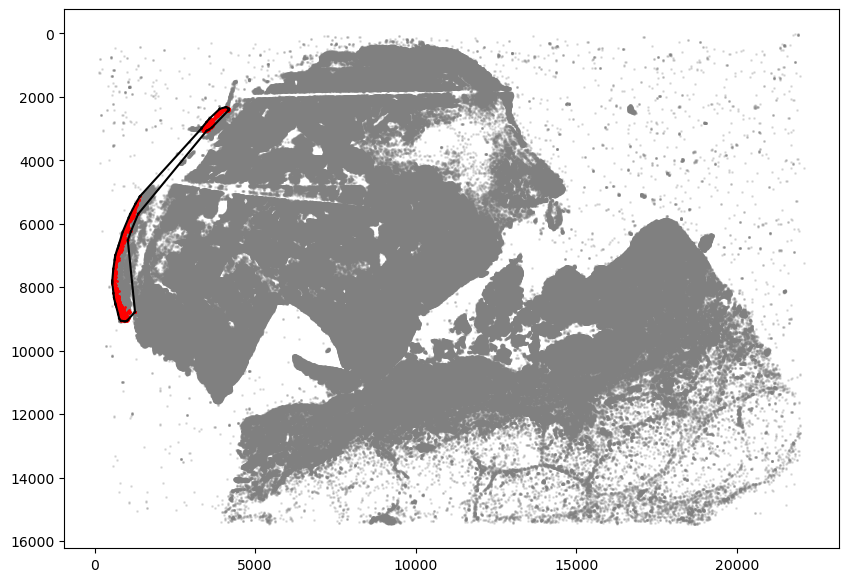

In [60]:
communityIndexList = [5,8]#[1,2,5,6,8]
epi_boundaries, epi_boundaries_components = spc.spatial.getBoundary(
    adata, communitycolumn, communityIndexList, alpha=3000,
    nedges_min = 10, nedges_out_min = 10
)
markersize = 1
fig, ax = plt.subplots(figsize=(10, 7))
## all points
ax.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=markersize, color="grey", alpha=0.2)
# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()
ax.scatter(xy[:,0], xy[:,1], s=markersize, color="r")
# Bounds of points in selected commnities
for edge in epi_boundaries:
    ax.plot(edge[:, 0], edge[:, 1], color="k")

ax.invert_yaxis()
plt.show()

In [57]:
import shapely
from shapely.geometry import Polygon, Point, MultiPolygon

def getDistanceFromRegion(adata, boundary, x="X_centroid", y="Y_centroid", 
                         region=None, name="distance", 
                         inplace=True, binned=False, binsize=10):
    """
    Get the distance of each cell from a point.
    :param adata: Anndata object
    :param boundary: List of boundary to get the distance from.
    :param x: Name of the column containing the x coordinate. Default is "X_centroid".
    :param y: Name of the column containing the y coordinate. Default is "Y_centroid".
    :param region: List of regions to consider. If None, consider all cells.
    :param name: Name of the column to store the distance in. Default is "distance".
    :param inplace: If True, add the distance column to adata.obs. If False, return a copy
    :param binned: If True, bin the distances into bins of size binsize. 
    :param binsize: Size of the bins to use for binning. Default is 10.
    :return: If inplace is False, return a copy of adata with the distance column added
    """
    if not inplace:
        adata = adata.copy()
    adata.obs[name] = np.nan
    region_obs = adata.obs.loc[adata.obs["region"].isin(region), :]
    points = region_obs[[x, y]].to_numpy()
    other_region_polygon = MultiPolygon(spc.spatial.getPolygons(boundary))
    other_region_polygon = shapely.make_valid(other_region_polygon)
    dists = []
    for point in points:
        dists.append(Point(point).distance(other_region_polygon))

    adata.obs.loc[adata.obs["region"].isin(region), name] = dists
    if binned:
        bins = adata.obs[name] - adata.obs[name] % binsize
        adata.obs[name + "_binned"] = "[" + bins.astype(str) + ", " + (bins + binsize).astype(str) + ")"
        adata.obs.loc[adata.obs[name + "_binned"] == "[nan, nan)", name + "_binned"] = np.nan
        adata.obs.sort_values(by=name, inplace=True)
        categories = adata.obs[name + "_binned"].dropna().unique()
        adata.obs[name + "_binned"] = pd.Categorical(adata.obs[name + "_binned"], ordered=True, categories=categories)
    if not inplace:
        return adata

In [61]:
getDistanceFromRegion(
    adata, epi_boundaries_components, region=["Tumor"],  
    name="distance_from_epidermis", binned=True, binsize=1500
)

/var/folders/0_/j7pzrt9j1xs_6xk0kgfxp0br0000gn/T/ipykernel_8697/1833239773.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/Users/boshenyan/anaconda3/envs/spatial-cells/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


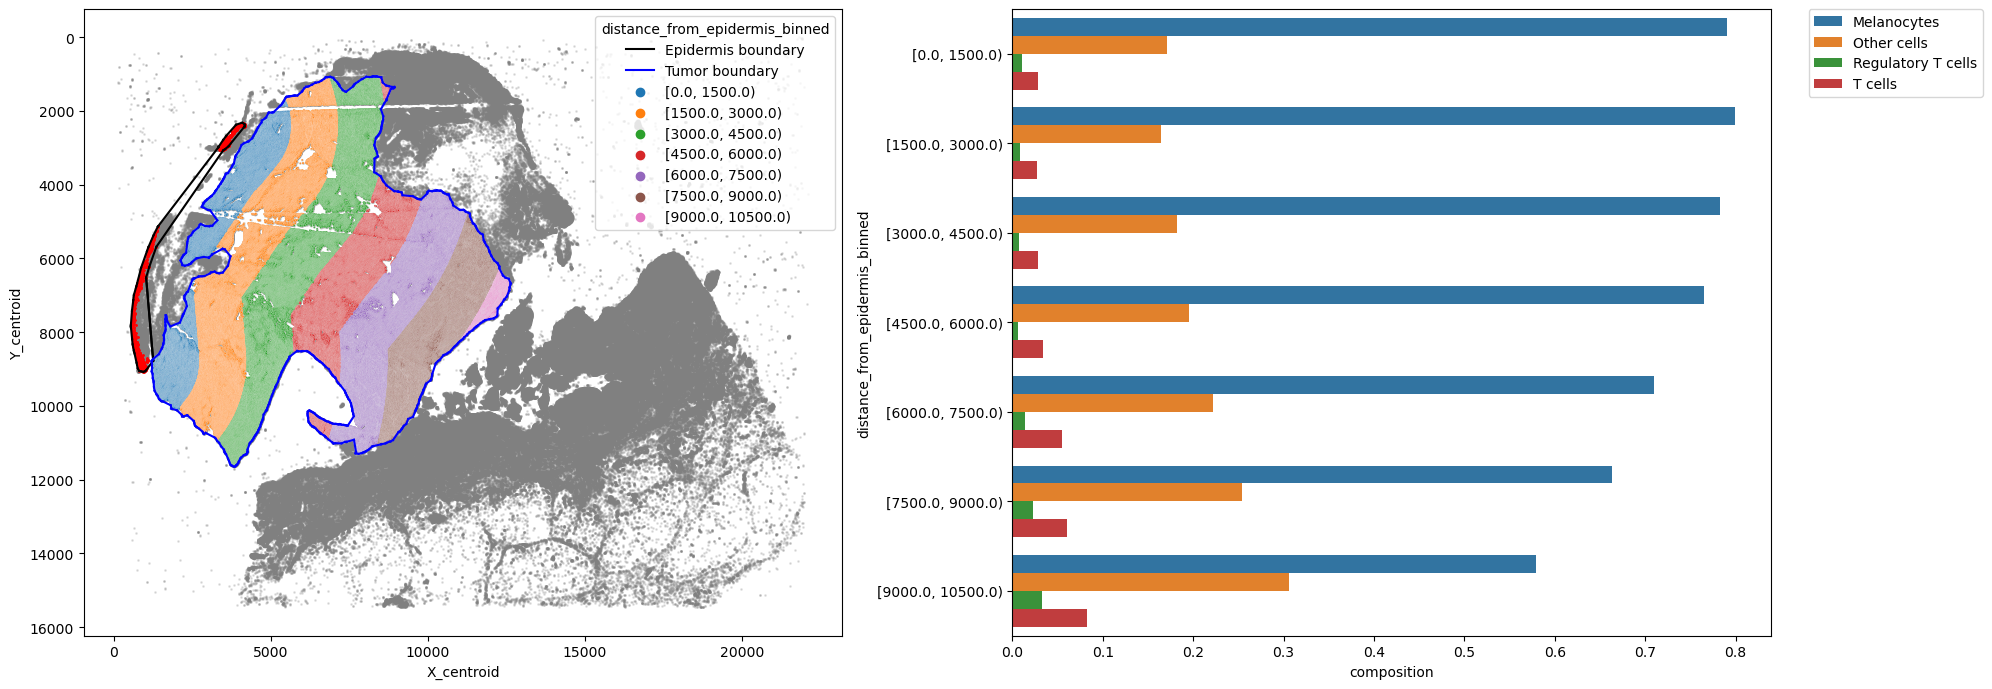

In [64]:
metric_col = "distance_from_epidermis_binned"
pheno = "pheno1"
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 7))

markersize = 1
## all points
ax1.scatter(*zip(*adata.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=markersize, color="grey", alpha=0.2)
# Points in selected commnities
xy = adata.obs[adata.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()
ax1.scatter(xy[:,0], xy[:,1], s=markersize, color="r")
# Bounds of points in selected commnities
for edge in epi_boundaries:
    ax1.plot(edge[:, 0], edge[:, 1], color="k")
ax1.plot(edge[:, 0], edge[:, 1], color="k", label="Epidermis boundary")

for edge in boundaries:
    ax1.plot(edge[:, 0], edge[:, 1], color="blue")
ax1.plot(edge[:, 0], edge[:, 1], color="blue", label="Tumor boundary")

sns.scatterplot(data=adata.obs, x="X_centroid", y="Y_centroid", hue=metric_col, alpha=0.8, s=2, ax=ax1)
ax1.invert_yaxis()
df = spc.tools.getRegionComposition(
    adata, [metric_col, pheno], regions=["Tumor"]
).sort_values(by=metric_col, ascending=False)

sns.barplot(data=df, y=metric_col, x="composition", hue=pheno, log=False, ax=ax2)
# ax1.legend(loc='upper right')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.show()

# Find immune cell infiltrated areas in tumor region

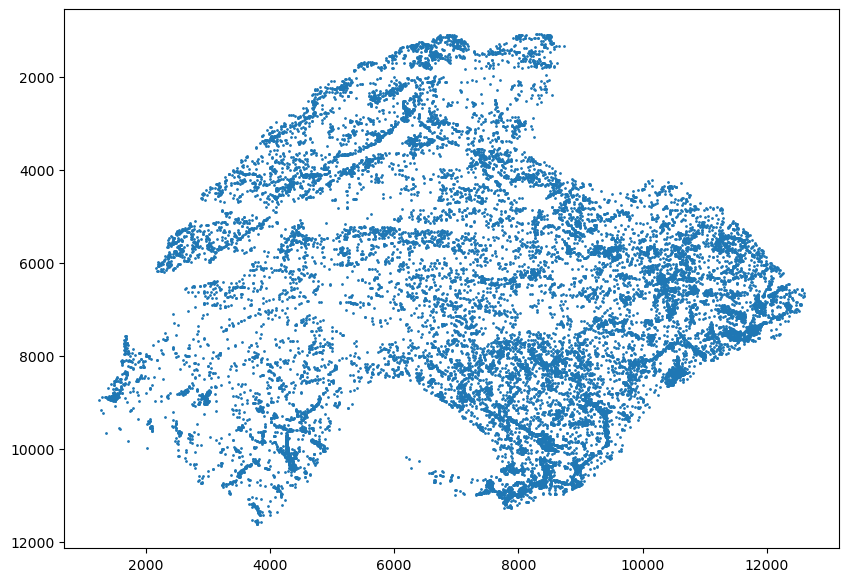

In [21]:
melano = adata[(adata.obs.pheno1 == "Melanocytes") & (adata.obs.region == "Tumor")]
tcells = adata[(adata.obs.pheno1 == "T cells") & (adata.obs.region == "Tumor")]
fig, ax = plt.subplots(figsize=(10, 7))
ax.invert_yaxis()
plt.scatter(tcells.obs["X_centroid"], tcells.obs["Y_centroid"], s=1)
plt.show()

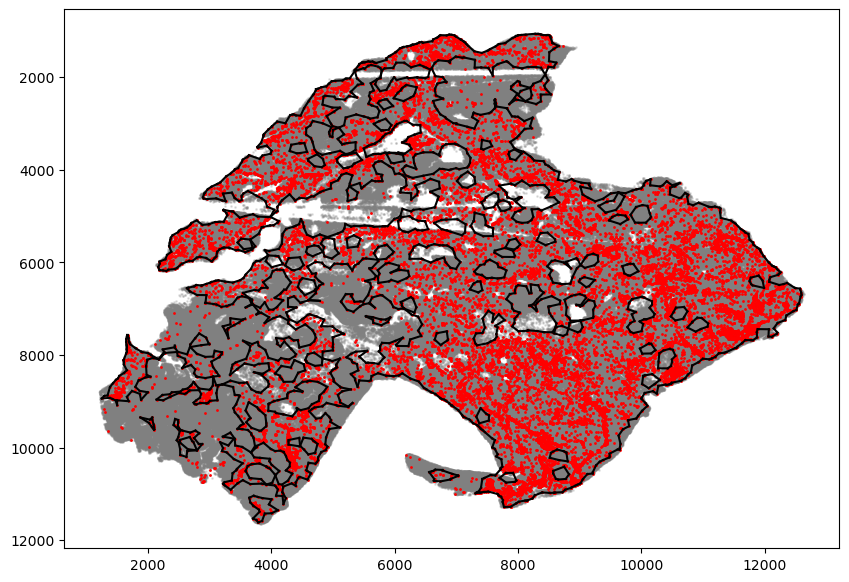

/Users/boshenyan/anaconda3/envs/spatial-cells/lib/python3.10/site-packages/spatialcells/spatial/_assignPointsToRegions.py:69: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  anndata.obs[assigncolumn] = default
100%|██████████| 22701/22701 [00:18<00:00, 1213.63it/s]

Assigned points to region: T


In [22]:
communitycolumn = "pheno1"
communityIndexList = ["T cells"]
tumor = adata[(adata.obs.region == "Tumor")]
nb, nb_components = spc.spatial.getBoundary(
    tumor, communitycolumn, communityIndexList, alpha=100,
    nedges_min = 6, nedges_out_min = 10
)
markersize = 1
fig, ax = plt.subplots(figsize=(10, 7))
## all points
ax.scatter(*zip(*tumor.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=markersize, color="grey", alpha=0.2)
# Points in selected commnities
xy = tumor.obs[tumor.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()
ax.scatter(xy[:,0], xy[:,1], s=markersize, color="r")
# Bounds of points in selected commnities
for edge in nb:
    ax.plot(edge[:, 0], edge[:, 1], color="k")
ax.invert_yaxis()
plt.show()

spc.spatial.assignPointsToRegions(
    tcells, [nb_components], ["T"],
    assigncolumn="tumor_immune_region", default="F"
)

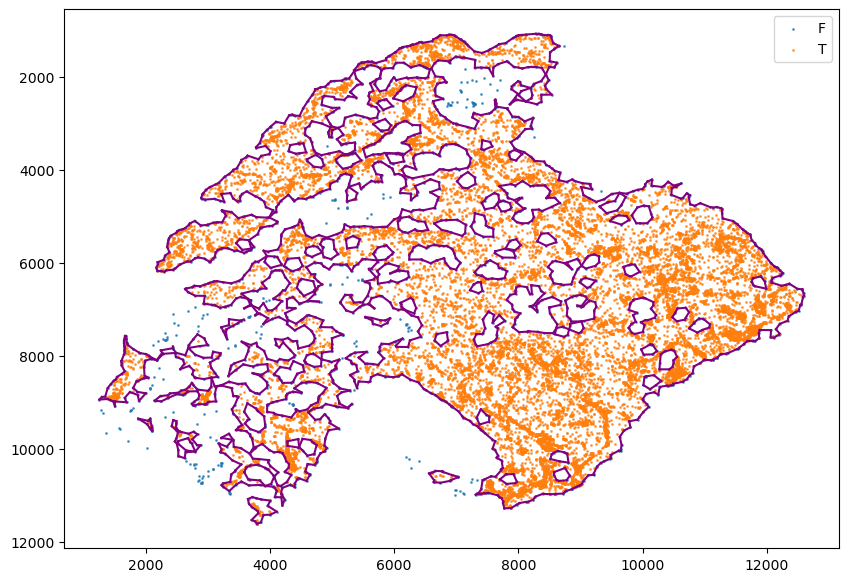

In [23]:
point_size = 1
fig, ax = plt.subplots(figsize=(10, 7))
for region in sorted(set(tcells.obs['tumor_immune_region'])):
    tmp = tcells.obs[tcells.obs.tumor_immune_region==region]
    ax.scatter(*zip(*tmp[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=point_size, alpha=0.7, label = region)
# Bounds of points in selected commnities
for ed in nb:
    ax.plot(ed[:, 0], ed[:, 1], color="purple")
# Extended bounds of points in selected commnities
# for ed in extended_boundaries:
#     ax.plot(ed[:, 0], ed[:, 1], color="red")
plt.legend(loc="upper right")
ax.invert_yaxis()
plt.show()

In [24]:
tcells = tcells[(tcells.obs.tumor_immune_region == "T")]
print(len(melano), len(tcells))
dists = spc.tools.getMinCellTypesDistance(melano, tcells)
adata.obs.loc[(adata.obs.pheno1 == "Melanocytes") & (adata.obs.region == "Tumor"), "dist"] = dists

435065 20294


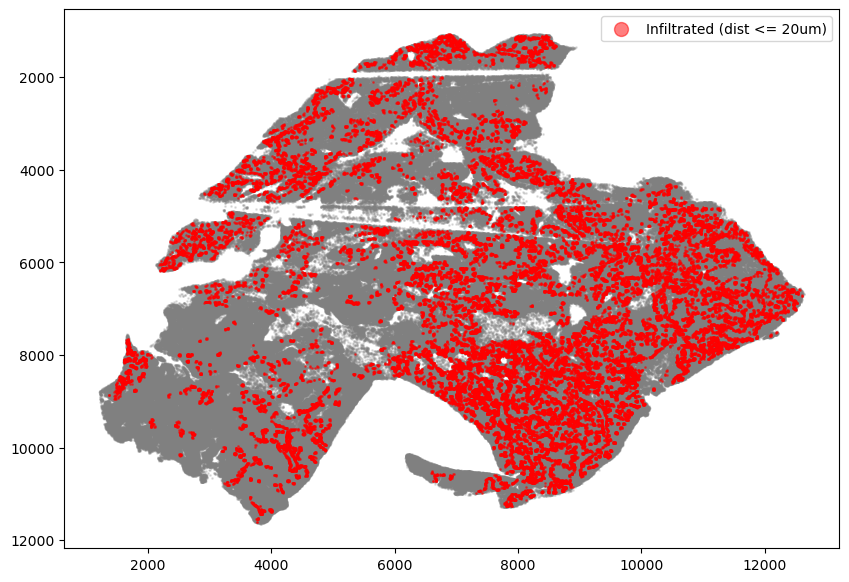

In [25]:
threshold = 20
adata.obs["dist_binned"] = (adata.obs["dist"] <= threshold)
infiltrated = adata.obs[(adata.obs.pheno1 == "Melanocytes") & (adata.obs.region == "Tumor") & (adata.obs.dist_binned == True)]
non_infiltrated = adata.obs[(adata.obs.pheno1 == "Melanocytes") & (adata.obs.region == "Tumor") & (adata.obs.dist_binned == False)]
fig, ax = plt.subplots(figsize=(10, 7))
ax.invert_yaxis()
region = adata.obs[(adata.obs.region == "Tumor")]
# plt.scatter(non_infiltrated["X_centroid"], non_infiltrated["Y_centroid"], s=1, alpha=0.2, color="grey", label=f"Non-infiltrated (dist > {threshold}um)")
plt.scatter(region["X_centroid"], region["Y_centroid"], s=1, alpha=0.2, color="grey")
plt.scatter(infiltrated["X_centroid"], infiltrated["Y_centroid"], s=1, alpha=0.5, color="red", label=f"Infiltrated (dist <= {threshold}um)")
plt.legend(markerscale=10)
plt.show()

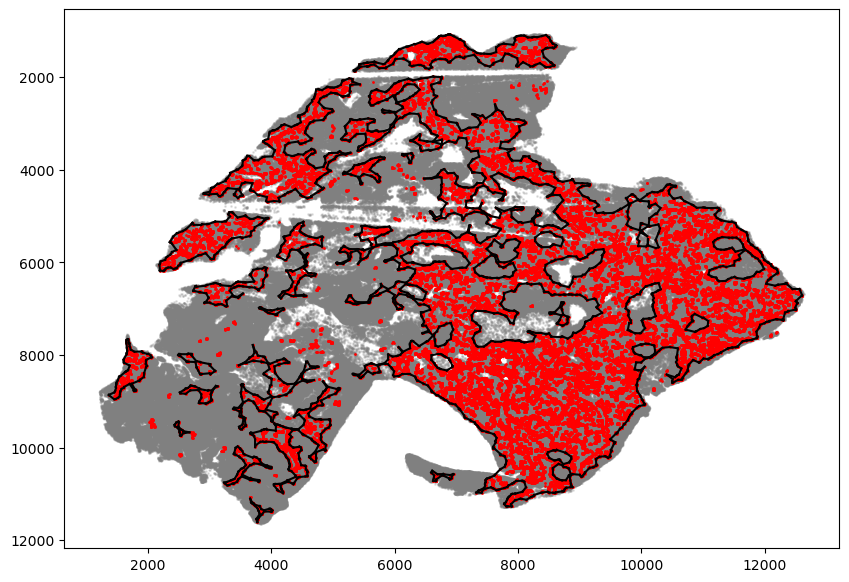

In [26]:
communitycolumn = "dist_binned"
communityIndexList = [True]
tumor = adata[(adata.obs.region == "Tumor")]
nb, nb_components = spc.spatial.getBoundary(
    tumor, communitycolumn, communityIndexList, alpha=threshold*4,
    nedges_min = 20, nedges_out_min = 20
)
# nextended_boundaries, nextended_boundary_components = spc.spatial.getExtendedBoundary(
#     nb_components, offset=10, minsize=10
# )
markersize = 1
fig, ax = plt.subplots(figsize=(10, 7))
## all points
ax.scatter(*zip(*tumor.obs[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=markersize, color="grey", alpha=0.2)
# Points in selected commnities
xy = tumor.obs[tumor.obs[communitycolumn].isin(communityIndexList)][
        ["X_centroid", "Y_centroid"]
    ].to_numpy()
ax.scatter(xy[:,0], xy[:,1], s=markersize, color="r")
# Bounds of points in selected commnities
for edge in nb:
    ax.plot(edge[:, 0], edge[:, 1], color="k")
# Extended bounds of points in selected commnities
# for edge in nextended_boundaries:
#     ax.plot(edge[:, 0], edge[:, 1], color="b")
ax.invert_yaxis()
plt.show()

/Users/boshenyan/anaconda3/envs/spatial-cells/lib/python3.10/site-packages/spatialcells/spatial/_assignPointsToRegions.py:69: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  anndata.obs[assigncolumn] = default
100%|██████████| 579701/579701 [07:08<00:00, 1352.63it/s]


Assigned points to region: TIL


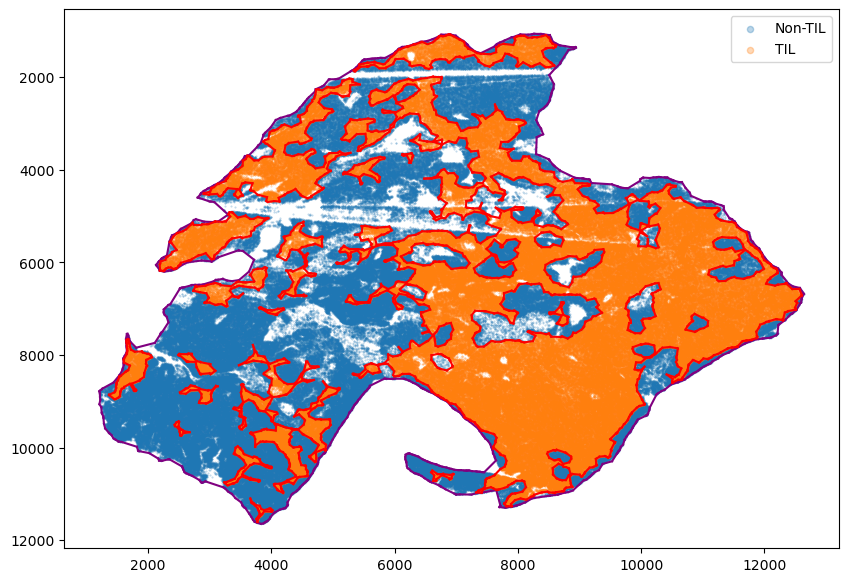

In [27]:
spc.spatial.assignPointsToRegions(
    tumor, [nb_components], ["TIL"], 
    assigncolumn="TIL", default="Non-TIL"
)
point_size = 0.2
fig, ax = plt.subplots(figsize=(10, 7))
for region in sorted(set(tumor.obs['TIL'])):
    tmp = tumor.obs[tumor.obs.TIL==region]
    ax.scatter(*zip(*tmp[["X_centroid", "Y_centroid"]].to_numpy()), 
           s=point_size, alpha=0.3, label = region)
# Bounds of points in selected commnities
for ed in boundaries:
    ax.plot(ed[:, 0], ed[:, 1], color="purple")
# Extended bounds of points in selected commnities
for ed in nb:
    ax.plot(ed[:, 0], ed[:, 1], color="red")
plt.legend(loc="upper left")
ax.invert_yaxis()
plt.legend(markerscale=10)
plt.show()

In [28]:
tumor_area = spc.tools.getRegionArea(boundaries_components)
overall_density = spc.tools.getRegionDensity(adata, "Tumor", boundaries_components).values[0] * 100**2

infiltrated_area = spc.tools.getRegionArea(nb_components)
tumor.obs["region"] = tumor.obs["TIL"]
# overall_density = spc.tools.getRegionDensity(adata, ["TIL", "Non-TIL"], boundaries_components).values[0] * 100**2
density_by_phenotype = spc.tools.getRegionDensity(
    tumor, ["TIL"], nb_components, phenotype_col="pheno1"
) * 100**2
til_composition = spc.tools.getRegionComposition(tumor, "pheno1", regions=["TIL"])
nontil_composition = spc.tools.getRegionComposition(tumor, "pheno1", regions=["Non-TIL"])
print(f"\nTumor area: {tumor_area:.3f}um2")
print(f"Infiltrated area: {infiltrated_area:.3f}um2")
print(f"Ratio of infiltrated area: {infiltrated_area/tumor_area:.3f}")
# print(f"\nCell density in tumor area: {overall_density:.3f} cells/100um2")
print(f"\nCell phenotype density in infiltrated area per 100um2: \n-----------")
print(density_by_phenotype)
print("\nCell phenotype composition in infiltrated area:\n-----------")
print(til_composition)
print("\nCell phenotype composition in non-infiltrated area:\n-----------")
print(nontil_composition)


Tumor area: 67119300.932um2
Infiltrated area: 29751301.233um2
Ratio of infiltrated area: 0.443

Cell phenotype density in infiltrated area per 100um2: 
-----------
pheno1
Melanocytes           68.976143
Other cells           21.498892
T cells                5.988310
Regulatory T cells     1.567663
Name: count, dtype: float64

Cell phenotype composition in infiltrated area:
-----------
               pheno1  cell_count  composition
0         Melanocytes      205213     0.703616
1         Other cells       63962     0.219307
2             T cells       17816     0.061086
3  Regulatory T cells        4664     0.015991

Cell phenotype composition in non-infiltrated area:
-----------
               pheno1  cell_count  composition
0         Melanocytes      229852     0.797970
1         Other cells       51203     0.177760
2             T cells        4885     0.016959
3  Regulatory T cells        2106     0.007311
